
# **Transformación de Datos**

Una vez que los datos crudos están en una base de datos, el siguiente paso es transformarlos para generar una tabla analítica, lo que nos permitirá realizar el análisis exploratorio de datos (EDA) y aplicar técnicas de aprendizaje automático (Machine Learning).

In [233]:
import pandas as pd
import os
import pandas as pd
from sqlalchemy import create_engine
import dotenv


## Conexión a la Base de Datos Crudos

In [234]:
# Se usan variables del sistema para almacenar los datos de conexión a la base de datos
# Esto como buena practiva para que no queden disponibles al mundo en un repositorio publico.
dotenv.load_dotenv("vars.env", override=True)

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

conn = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}', echo=False)

## Transformacion Variables de Generación - Sistema

### Generación del Sistema
-   Metrica: Generacion por Sistema
-   Unidad: kWh	
-   Descripción: Generacion neta de cada una de las plantas Nacionales en sus puntos de frontera.

In [235]:
sql_query = """SELECT * FROM generacion_sistema"""
df_generacion_sistema = pd.read_sql_query(sql_query, con=conn)
df_generacion_sistema['Date'] = pd.to_datetime(df_generacion_sistema['Date'])
df_generacion_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,5609982.23,5296750.71,4919467.58,4638776.22,4442074.76,4279026.64,3827254.47,3832573.95,...,4391372.59,4365640.95,4605721.12,6021430.06,6527391.35,6261393.45,5776398.57,5211439.50,4714078.01,2010-01-01
1,Sistema,Sistema,4443442.83,4238022.31,4153685.87,4103574.79,4153986.60,4252501.43,4185993.85,4479587.60,...,5397357.88,5317214.52,5482854.99,6895377.37,7356071.75,7109606.16,6611477.08,5931707.62,5211930.81,2010-01-02
2,Sistema,Sistema,4771417.74,4520041.29,4364500.03,4210941.04,4205070.55,4312551.86,4156670.92,4331637.24,...,5015866.10,4981069.04,5169045.72,6637669.36,7126930.30,6924827.71,6432570.74,5752050.08,5135978.48,2010-01-03
3,Sistema,Sistema,4705250.02,4493314.06,4399068.67,4395569.56,4475996.61,4777750.57,4911096.21,5322214.49,...,6618343.03,6458778.34,6529860.50,7819390.86,8232402.15,7884258.05,7197982.57,6288573.58,5535400.79,2010-01-04
4,Sistema,Sistema,5171964.92,4939629.25,4840107.60,4774763.87,4949684.01,5195571.83,5362721.47,5742326.06,...,6778398.35,6715045.20,6745497.24,8023899.14,8336888.23,7929022.67,7243496.48,6378988.75,5737144.04,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,Sistema,Sistema,8518210.80,8198137.14,7966493.50,7848538.15,7993954.30,8373795.23,8533971.50,8989609.97,...,10224371.17,10138968.61,9944771.52,10267157.48,10388113.98,10186516.32,9774795.94,9269233.15,8783850.22,2024-04-26
5230,Sistema,Sistema,8416268.81,8139684.03,7934365.14,7801216.87,7802711.66,7866953.71,8060693.66,8611512.50,...,9613448.98,9515583.90,9453804.19,10022279.38,10070282.41,9806988.02,9391935.06,8934686.71,8515651.18,2024-04-27
5231,Sistema,Sistema,8153358.39,7823646.09,7495560.68,7290789.06,7186795.65,7058942.05,6899473.59,7167562.93,...,8373980.81,8391670.64,8366776.05,9037799.05,9296771.60,9194946.81,8963686.66,8545982.69,8101750.18,2024-04-28
5232,Sistema,Sistema,7755006.39,7559477.81,7424995.07,7358043.41,7541190.63,7993483.44,8218854.74,8737461.99,...,10365625.70,10314129.94,10040895.25,10521997.09,10740452.13,10521840.29,10125689.57,9473347.41,8842359.25,2024-04-29


Como se puede observar en las columnas, tenemos un valor para cada hora del día, la fecha de toma de esos datos, y algunos valores adicionales que también exporta la API. Lo que haremos es convertir la fecha en el índice de la tabla, sumar (o promediar) los valores horarios para obtener un valor diario, e ir consolidando estos datos en un DataFrame analítico.

In [236]:
df_generacion_sistema = df_generacion_sistema.set_index('Date')
df_generacion_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour15,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,Sistema,Sistema,5609982.23,5296750.71,4919467.58,4638776.22,4442074.76,4279026.64,3827254.47,3832573.95,...,4457991.95,4391372.59,4365640.95,4605721.12,6021430.06,6527391.35,6261393.45,5776398.57,5211439.50,4714078.01
2010-01-02,Sistema,Sistema,4443442.83,4238022.31,4153685.87,4103574.79,4153986.60,4252501.43,4185993.85,4479587.60,...,5473192.84,5397357.88,5317214.52,5482854.99,6895377.37,7356071.75,7109606.16,6611477.08,5931707.62,5211930.81
2010-01-03,Sistema,Sistema,4771417.74,4520041.29,4364500.03,4210941.04,4205070.55,4312551.86,4156670.92,4331637.24,...,5089743.12,5015866.10,4981069.04,5169045.72,6637669.36,7126930.30,6924827.71,6432570.74,5752050.08,5135978.48
2010-01-04,Sistema,Sistema,4705250.02,4493314.06,4399068.67,4395569.56,4475996.61,4777750.57,4911096.21,5322214.49,...,6702923.38,6618343.03,6458778.34,6529860.50,7819390.86,8232402.15,7884258.05,7197982.57,6288573.58,5535400.79
2010-01-05,Sistema,Sistema,5171964.92,4939629.25,4840107.60,4774763.87,4949684.01,5195571.83,5362721.47,5742326.06,...,6854886.19,6778398.35,6715045.20,6745497.24,8023899.14,8336888.23,7929022.67,7243496.48,6378988.75,5737144.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,Sistema,Sistema,8518210.80,8198137.14,7966493.50,7848538.15,7993954.30,8373795.23,8533971.50,8989609.97,...,10199680.49,10224371.17,10138968.61,9944771.52,10267157.48,10388113.98,10186516.32,9774795.94,9269233.15,8783850.22
2024-04-27,Sistema,Sistema,8416268.81,8139684.03,7934365.14,7801216.87,7802711.66,7866953.71,8060693.66,8611512.50,...,9669628.56,9613448.98,9515583.90,9453804.19,10022279.38,10070282.41,9806988.02,9391935.06,8934686.71,8515651.18
2024-04-28,Sistema,Sistema,8153358.39,7823646.09,7495560.68,7290789.06,7186795.65,7058942.05,6899473.59,7167562.93,...,8364289.97,8373980.81,8391670.64,8366776.05,9037799.05,9296771.60,9194946.81,8963686.66,8545982.69,8101750.18


In [237]:
df_generacion_sistema['generacion_sistema_daily'] = df_generacion_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_generacion_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,generacion_sistema_daily
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,Sistema,Sistema,5609982.23,5296750.71,4919467.58,4638776.22,4442074.76,4279026.64,3827254.47,3832573.95,...,4391372.59,4365640.95,4605721.12,6021430.06,6527391.35,6261393.45,5776398.57,5211439.50,4714078.01,1.154191e+08
2010-01-02,Sistema,Sistema,4443442.83,4238022.31,4153685.87,4103574.79,4153986.60,4252501.43,4185993.85,4479587.60,...,5397357.88,5317214.52,5482854.99,6895377.37,7356071.75,7109606.16,6611477.08,5931707.62,5211930.81,1.276812e+08
2010-01-03,Sistema,Sistema,4771417.74,4520041.29,4364500.03,4210941.04,4205070.55,4312551.86,4156670.92,4331637.24,...,5015866.10,4981069.04,5169045.72,6637669.36,7126930.30,6924827.71,6432570.74,5752050.08,5135978.48,1.236378e+08
2010-01-04,Sistema,Sistema,4705250.02,4493314.06,4399068.67,4395569.56,4475996.61,4777750.57,4911096.21,5322214.49,...,6618343.03,6458778.34,6529860.50,7819390.86,8232402.15,7884258.05,7197982.57,6288573.58,5535400.79,1.459575e+08
2010-01-05,Sistema,Sistema,5171964.92,4939629.25,4840107.60,4774763.87,4949684.01,5195571.83,5362721.47,5742326.06,...,6778398.35,6715045.20,6745497.24,8023899.14,8336888.23,7929022.67,7243496.48,6378988.75,5737144.04,1.521480e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,Sistema,Sistema,8518210.80,8198137.14,7966493.50,7848538.15,7993954.30,8373795.23,8533971.50,8989609.97,...,10224371.17,10138968.61,9944771.52,10267157.48,10388113.98,10186516.32,9774795.94,9269233.15,8783850.22,2.246048e+08
2024-04-27,Sistema,Sistema,8416268.81,8139684.03,7934365.14,7801216.87,7802711.66,7866953.71,8060693.66,8611512.50,...,9613448.98,9515583.90,9453804.19,10022279.38,10070282.41,9806988.02,9391935.06,8934686.71,8515651.18,2.171655e+08
2024-04-28,Sistema,Sistema,8153358.39,7823646.09,7495560.68,7290789.06,7186795.65,7058942.05,6899473.59,7167562.93,...,8373980.81,8391670.64,8366776.05,9037799.05,9296771.60,9194946.81,8963686.66,8545982.69,8101750.18,1.941888e+08


In [238]:
df_generacion_sistema_daily = df_generacion_sistema[['generacion_sistema_daily']]
df_generacion_sistema_daily

,generacion_sistema_daily
Date,
2010-01-01,1.154191e+08
2010-01-02,1.276812e+08
2010-01-03,1.236378e+08
2010-01-04,1.459575e+08
2010-01-05,1.521480e+08
...,...
2024-04-26,2.246048e+08
2024-04-27,2.171655e+08
2024-04-28,1.941888e+08


### Generación del Sistema Ideal
-   Metrica: Generación Ideal por Sistema
-   Unidad: kWh	
-   Descripción: Despacho de generacion que resulta de considerar una red de transporte inexistente

In [239]:
sql_query = """SELECT * FROM generacion_ideal_sistema"""
df_generacion_ideal_sistema = pd.read_sql_query(sql_query, con=conn)
df_generacion_ideal_sistema['Date'] = pd.to_datetime(df_generacion_ideal_sistema['Date'])
df_generacion_ideal_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,5609982.23,5299387.09,4922337.76,4640952.55,4443431.20,4280072.11,3828774.82,3832979.13,...,4392140.29,4366427.63,4606016.29,6021430.06,6527391.35,6263172.04,5779281.34,5212138.25,4714247.65,2010-01-01
1,Sistema,Sistema,4445348.51,4238116.21,4154887.32,4103709.79,4153986.60,4252501.43,4186498.45,4480615.46,...,5397357.88,5318190.02,5484348.49,6895377.37,7356107.90,7110891.37,6612818.22,5934135.44,5214100.60,2010-01-02
2,Sistema,Sistema,4772268.38,4520104.69,4365723.51,4211679.57,4205364.41,4312551.86,4156670.92,4333251.97,...,5016125.95,4981354.24,5169667.20,6637669.36,7126930.30,6927793.22,6433970.64,5753971.20,5137059.49,2010-01-03
3,Sistema,Sistema,4705845.03,4493923.68,4400230.86,4396643.54,4475996.61,4778560.19,4912357.20,5323877.68,...,6517107.95,6357582.34,6428430.50,7712972.01,8130900.15,7782972.05,7096426.57,6186918.31,5434024.79,2010-01-04
4,Sistema,Sistema,5044349.31,4810224.85,4711179.46,4644547.47,4821049.57,5066868.38,5233620.74,5612777.12,...,6648597.90,6586555.45,6617438.28,7888852.40,8206986.44,7800736.46,7115549.68,6250156.98,5605618.05,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,Sistema,Sistema,8518210.80,8198137.14,7966493.50,7848538.15,7993954.30,8373795.23,8533971.50,8989609.97,...,10224371.17,10138968.61,9944771.52,10267157.48,10388113.98,10186516.32,9774795.94,9269233.15,8783850.22,2024-04-26
5230,Sistema,Sistema,8416268.81,8139684.03,7934365.14,7801216.87,7802711.66,7866953.71,8060693.66,8611512.50,...,9613448.98,9515583.90,9453804.19,10022279.38,10070282.41,9806988.02,9391935.06,8934686.71,8515651.18,2024-04-27
5231,Sistema,Sistema,8153358.39,7823646.09,7495560.68,7290789.06,7186795.65,7058942.05,6899473.59,7167562.93,...,8373980.81,8391670.64,8366776.05,9037799.05,9296771.60,9195967.42,8965875.21,8547088.54,8101750.18,2024-04-28
5232,Sistema,Sistema,7755006.39,7559477.81,7424995.07,7358043.41,7541190.63,7993483.44,8218854.74,8737461.99,...,10365625.70,10315355.57,10040895.25,10521997.09,10741050.68,10522650.66,10127382.98,9476883.76,8842359.25,2024-04-29


In [240]:
df_generacion_ideal_sistema = df_generacion_ideal_sistema.set_index('Date')
df_generacion_ideal_sistema['generacion_ideal_sistema_daily'] = df_generacion_ideal_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_generacion_ideal_sistema_daily = df_generacion_ideal_sistema[['generacion_ideal_sistema_daily']]
df_generacion_ideal_sistema_daily


,generacion_ideal_sistema_daily
Date,
2010-01-01,1.154409e+08
2010-01-02,1.276983e+08
2010-01-03,1.236548e+08
2010-01-04,1.444114e+08
2010-01-05,1.490348e+08
...,...
2024-04-26,2.246048e+08
2024-04-27,2.171655e+08
2024-04-28,1.941931e+08


#### Union Dataset

In [241]:
df_consolidated = pd.merge(df_generacion_sistema_daily, df_generacion_ideal_sistema_daily, on="Date", how='outer')
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily
Date,,
2010-01-01,1.154191e+08,1.154409e+08
2010-01-02,1.276812e+08,1.276983e+08
2010-01-03,1.236378e+08,1.236548e+08
2010-01-04,1.459575e+08,1.444114e+08
2010-01-05,1.521480e+08,1.490348e+08
...,...,...
2024-04-26,2.246048e+08,2.246048e+08
2024-04-27,2.171655e+08,2.171655e+08
2024-04-28,1.941888e+08,1.941931e+08


### Perdidas del Sistema
-   Metrica: Perdidas de Energía por Sistema
-   Unidad: kWh	
-   Descripción: Cantidad de las inyecciones de energia al Sistema de Transmision Nacional (flujos de baja a alta tension), menos la cantidad de los flujos que salieron del Sistema (flujos de alta a baja tension).

In [242]:
sql_query = """SELECT * FROM perdidas_sistema"""
df_perdidas_sistema = pd.read_sql_query(sql_query, con=conn)
df_perdidas_sistema['Date'] = pd.to_datetime(df_perdidas_sistema['Date'])
df_perdidas_sistema

,Column1,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,0,Sistema,Sistema,105774.61,102118.61,83645.43,76479.29,86936.10,90440.22,63824.36,...,91227.73,72140.80,81412.93,101288.44,117722.66,105167.30,117369.59,117319.88,63782.69,2010-01-01
1,1,Sistema,Sistema,67249.86,68144.93,80334.54,71838.53,82755.38,73647.53,57781.19,...,76224.22,73456.17,80452.90,82028.96,123472.06,135808.67,136890.05,153906.03,138367.05,2010-01-02
2,2,Sistema,Sistema,85150.73,82398.64,72624.72,68972.34,94164.66,91730.56,63489.63,...,103027.98,99768.55,87914.68,91854.79,156818.60,148016.20,149224.20,147846.70,148218.55,2010-01-03
3,3,Sistema,Sistema,105862.54,105914.33,78999.12,73351.31,46846.53,69821.14,58761.25,...,114344.91,69098.95,63711.63,74057.35,128479.40,145726.62,146592.45,114760.41,41776.99,2010-01-04
4,4,Sistema,Sistema,76579.31,95728.29,86616.09,63866.76,79934.42,66618.63,59586.27,...,87785.94,82425.43,58046.85,128688.74,122294.09,110237.18,112819.66,135709.39,216910.06,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,5229,Sistema,Sistema,126262.35,125898.61,125845.56,116964.45,100126.47,112034.68,125497.24,...,169304.69,188228.31,245061.69,143956.22,152486.44,158102.02,154361.52,141111.40,145943.10,2024-04-26
5230,5230,Sistema,Sistema,145872.60,142324.34,140287.40,134343.81,128968.31,130514.03,118078.49,...,137922.40,146466.64,146785.72,150258.12,166424.90,164811.00,156758.48,138097.20,126882.77,2024-04-27
5231,5231,Sistema,Sistema,131308.39,125172.03,125330.72,126857.51,124666.49,118256.46,106743.08,...,126654.41,117944.98,108010.41,122707.43,129748.61,129918.48,129930.01,117732.00,110637.54,2024-04-28
5232,5232,Sistema,Sistema,97878.18,96572.57,95367.40,95241.84,78463.46,95768.18,101123.09,...,128655.82,142992.38,127562.01,136332.38,151891.98,148351.95,154116.17,133460.55,113115.72,2024-04-29


In [243]:
df_perdidas_sistema = df_perdidas_sistema.set_index('Date')
df_perdidas_sistema['perdidas_sistema_daily'] = df_perdidas_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_perdidas_sistema_daily = df_perdidas_sistema[['perdidas_sistema_daily']]
df_perdidas_sistema_daily

,perdidas_sistema_daily
Date,
2010-01-01,2079352.97
2010-01-02,2226467.46
2010-01-03,2509638.35
2010-01-04,2032914.64
2010-01-05,2278901.51
...,...
2024-04-26,3468541.50
2024-04-27,3317765.92
2024-04-28,2880163.08


### Union DataSets

In [244]:
df_consolidated = df_consolidated.join(df_perdidas_sistema_daily, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily
Date,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97
2010-01-02,1.276812e+08,1.276983e+08,2226467.46
2010-01-03,1.236378e+08,1.236548e+08,2509638.35
2010-01-04,1.459575e+08,1.444114e+08,2032914.64
2010-01-05,1.521480e+08,1.490348e+08,2278901.51
...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50
2024-04-27,2.171655e+08,2.171655e+08,3317765.92
2024-04-28,1.941888e+08,1.941931e+08,2880163.08


### Volumen Útil del Sistema
-   Metrica: Volumen Útil diario Energía Sistema
-   Unidad: kWh	
-   Descripción: Volumen almacenado por encima del Nivel Minimo Tecnico, reportado diariamente por los agentes. En % corresponde a la relacion entre el Volumen Util Diario y la Capacidad Util del Embalse

In [245]:
sql_query = """select * from volumen_util_energia_sistema"""
df_volumen_util_energia_sistema = pd.read_sql_query(sql_query, con=conn)
df_volumen_util_energia_sistema['Date'] = pd.to_datetime(df_volumen_util_energia_sistema['Date'])
df_volumen_util_energia_sistema

,Id,Value,Date
0,Sistema,1.000661e+10,2010-01-01
1,Sistema,9.995147e+09,2010-01-02
2,Sistema,9.992677e+09,2010-01-03
3,Sistema,9.965341e+09,2010-01-04
4,Sistema,9.926760e+09,2010-01-05
...,...,...,...
5229,Sistema,5.399084e+09,2024-04-26
5230,Sistema,5.454065e+09,2024-04-27
5231,Sistema,5.557993e+09,2024-04-28
5232,Sistema,5.672510e+09,2024-04-29


In [246]:
df_volumen_util_energia_sistema = df_volumen_util_energia_sistema.set_index('Date')


In [247]:
df_volumen_util_energia_sistema = df_volumen_util_energia_sistema[["Value"]]
df_volumen_util_energia_sistema

,Value
Date,
2010-01-01,1.000661e+10
2010-01-02,9.995147e+09
2010-01-03,9.992677e+09
2010-01-04,9.965341e+09
2010-01-05,9.926760e+09
...,...
2024-04-26,5.399084e+09
2024-04-27,5.454065e+09
2024-04-28,5.557993e+09


In [248]:
df_volumen_util_energia_sistema = df_volumen_util_energia_sistema.rename({"Value":"volumen_util_energia_sistema_daily"},axis=1)


In [249]:
df_volumen_util_energia_sistema

,volumen_util_energia_sistema_daily
Date,
2010-01-01,1.000661e+10
2010-01-02,9.995147e+09
2010-01-03,9.992677e+09
2010-01-04,9.965341e+09
2010-01-05,9.926760e+09
...,...
2024-04-26,5.399084e+09
2024-04-27,5.454065e+09
2024-04-28,5.557993e+09


In [250]:
df_consolidated = df_consolidated.join(df_volumen_util_energia_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily
Date,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09
...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09


### Emisiones CO2
-   Metrica: Emisiones de CO2 por RecursoComb
-   Unidad: TonCO2	
-   Descripción: Emisiones totales de Dióxido de Carbono – CO2 de las plantas de generación registradas ante el CND. Incluye tanto las obtenidas con base en el reporte de consumo de combustible como las aproximadas po

In [251]:
sql_query = """select
	sum("Values_Hour01") as Values_Hour01,
	sum("Values_Hour02") as Values_Hour02,
	sum("Values_Hour03") as Values_Hour03,
	sum("Values_Hour04") as Values_Hour04,
	sum("Values_Hour05") as Values_Hour05,
	sum("Values_Hour06") as Values_Hour06,
	sum("Values_Hour07") as Values_Hour07,
	sum("Values_Hour08") as Values_Hour08,
	sum("Values_Hour09") as Values_Hour09,
	sum("Values_Hour10") as Values_Hour10,
	sum("Values_Hour11") as Values_Hour11,
	sum("Values_Hour12") as Values_Hour12,
	sum("Values_Hour13") as Values_Hour13,
	sum("Values_Hour14") as Values_Hour14,
	sum("Values_Hour15") as Values_Hour15,
	sum("Values_Hour16") as Values_Hour16,
	sum("Values_Hour17") as Values_Hour17,
	sum("Values_Hour18") as Values_Hour18,
	sum("Values_Hour19") as Values_Hour19,
	sum("Values_Hour20") as Values_Hour20,
	sum("Values_Hour21") as Values_Hour21,
	sum("Values_Hour22") as Values_Hour22,
	sum("Values_Hour23") as Values_Hour23,
	sum("Values_Hour24") as Values_Hour24,
	"Date"
from
	"emisiones_CO2eq"
group by
	"Date"
order by "Date"
 """
df_emisiones_co2 = pd.read_sql_query(sql_query, con=conn)
df_emisiones_co2['Date'] = pd.to_datetime(df_emisiones_co2['Date'])
df_emisiones_co2



,values_hour01,values_hour02,values_hour03,values_hour04,values_hour05,values_hour06,values_hour07,values_hour08,values_hour09,values_hour10,...,values_hour16,values_hour17,values_hour18,values_hour19,values_hour20,values_hour21,values_hour22,values_hour23,values_hour24,Date
0,982.51357,973.70994,949.80639,923.35236,893.46146,818.61236,721.23775,622.38146,584.16120,758.56847,...,979.23351,980.77074,978.99164,1017.27466,1047.50080,1061.95948,1050.08198,1035.31430,997.54166,2018-01-01
1,969.66431,958.84993,948.01217,918.66891,965.83198,993.73744,980.13283,991.47346,990.85532,991.19799,...,1111.47404,1028.94417,1038.89905,1222.11954,1235.73129,1237.34847,1181.49744,1184.94840,1132.45481,2018-01-02
2,1006.26347,898.39171,854.46299,832.88603,840.02538,925.60409,884.32112,886.18319,849.16780,894.82538,...,1052.30837,1033.42262,985.91622,1092.55974,1092.63045,1094.79571,1084.75479,1060.20841,1018.82423,2018-01-03
3,1008.21515,1000.52854,1003.31703,945.55445,948.04193,947.21923,949.40115,951.33653,941.93272,930.83796,...,1129.18702,1087.76764,1054.21979,1186.76036,1203.09920,1194.90451,1181.60577,1166.55374,1150.76866,2018-01-04
4,1144.30585,1055.52117,987.78338,1003.41245,1018.34516,1028.49994,1029.65386,1033.37579,1034.68188,1039.02950,...,1277.65423,1236.12289,1211.15550,1324.99509,1342.45176,1335.75279,1323.55033,1312.34605,1313.38897,2018-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,3497.27157,3505.56682,3499.71447,3498.65321,3494.92907,3495.82335,3442.48834,3408.77173,3445.83163,3489.98144,...,3487.00185,3437.12371,3289.74861,3240.62920,3216.10868,3211.67628,3085.72708,3004.19667,3075.24165,2024-04-26
2308,2985.52549,3021.22030,2957.34461,2982.72259,2966.56382,2985.94149,2981.63957,2976.96007,2976.42212,2954.87771,...,3040.53201,3042.74382,3064.19956,3073.90099,3083.48335,3070.78428,3065.35926,3067.76012,3061.72652,2024-04-27
2309,2872.25488,2794.64682,2705.31792,2647.27252,2683.20175,2689.35159,2689.64160,2689.29899,2686.36944,2713.95197,...,2792.15248,2788.76217,2795.65538,2830.92170,2846.51483,2849.30068,2851.69028,2725.45148,2505.52869,2024-04-28
2310,2240.21437,2181.25868,2175.89063,2137.27981,2120.80624,2120.88415,2125.22205,2121.67948,2113.04968,2111.33802,...,2092.72915,2043.59834,2094.56582,2141.38192,2159.22056,2108.26424,2047.97652,2047.89540,2053.99547,2024-04-29


In [252]:
df_emisiones_co2 = df_emisiones_co2.set_index('Date')
df_emisiones_co2['emisiones_sistema_daily'] = df_emisiones_co2.loc[:, 'values_hour01':'values_hour24'].sum(axis=1)
df_emisiones_co2 = df_emisiones_co2[['emisiones_sistema_daily']]
df_emisiones_co2

,emisiones_sistema_daily
Date,
2018-01-01,22088.27195
2018-01-02,25335.71780
2018-01-03,23302.86237
2018-01-04,25198.28166
2018-01-05,28025.00174
...,...
2024-04-26,81390.03841
2024-04-27,72221.14808
2024-04-28,65899.83428


In [253]:
df_emisiones_co2 = df_emisiones_co2.rename({"Value":"Emisiones_CO2_sistema_daily"},axis=1)
df_emisiones_co2

,emisiones_sistema_daily
Date,
2018-01-01,22088.27195
2018-01-02,25335.71780
2018-01-03,23302.86237
2018-01-04,25198.28166
2018-01-05,28025.00174
...,...
2024-04-26,81390.03841
2024-04-27,72221.14808
2024-04-28,65899.83428


### Union DataSets

In [254]:
df_consolidated = df_consolidated.join(df_emisiones_co2, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily
Date,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN
...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428


### Aportes Energía Sistema

-   Metrica: Aportes  Energía por Rio
-   Unidad: kWh	
-   Descripción: Caudales en energia de los rios que aportan agua a algun embalse del SIN

In [255]:
sql_query = """select * from aportes_energia_sistema"""
df_aportes_energia_sistema = pd.read_sql_query(sql_query, con=conn)
df_aportes_energia_sistema['Date'] = pd.to_datetime(df_aportes_energia_sistema['Date'])
df_aportes_energia_sistema

,Id,Value,Date
0,Sistema,45616100,2010-01-01
1,Sistema,43097100,2010-01-02
2,Sistema,43400400,2010-01-03
3,Sistema,40410400,2010-01-04
4,Sistema,41190600,2010-01-05
...,...,...,...
5229,Sistema,175197100,2024-04-26
5230,Sistema,190925700,2024-04-27
5231,Sistema,206187700,2024-04-28
5232,Sistema,303206200,2024-04-29


In [256]:
df_aportes_energia_sistema = df_aportes_energia_sistema.set_index('Date')

In [257]:
df_aportes_energia_sistema = df_aportes_energia_sistema[["Value"]]
df_aportes_energia_sistema

,Value
Date,
2010-01-01,45616100
2010-01-02,43097100
2010-01-03,43400400
2010-01-04,40410400
2010-01-05,41190600
...,...
2024-04-26,175197100
2024-04-27,190925700
2024-04-28,206187700


In [258]:
df_aportes_energia_sistema = df_aportes_energia_sistema.rename({"Value":"aportes_energia_sistema_daily"},axis=1)
df_aportes_energia_sistema

,aportes_energia_sistema_daily
Date,
2010-01-01,45616100
2010-01-02,43097100
2010-01-03,43400400
2010-01-04,40410400
2010-01-05,41190600
...,...
2024-04-26,175197100
2024-04-27,190925700
2024-04-28,206187700


### Union datasets

In [259]:
df_consolidated = df_consolidated.join(df_aportes_energia_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily
Date,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600
...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700


### Aportes Energía Sistema Media Histórica

-   Metrica: Aportes Media Histórica Energía por Rio
-   Unidad: kWh	
-   Descripción: Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles 

In [260]:
sql_query = """SELECT * FROM aportes_energia_sistema_media_historica"""
df_aportes_energia_MediaHist_sistema = pd.read_sql_query(sql_query, con=conn)
df_aportes_energia_MediaHist_sistema['Date'] = pd.to_datetime(df_aportes_energia_MediaHist_sistema['Date'])
df_aportes_energia_MediaHist_sistema

,Id,Value,Date
0,Sistema,75130000,2010-01-01
1,Sistema,75130000,2010-01-02
2,Sistema,75130000,2010-01-03
3,Sistema,75130000,2010-01-04
4,Sistema,75130000,2010-01-05
...,...,...,...
5229,Sistema,222790000,2024-04-26
5230,Sistema,222790000,2024-04-27
5231,Sistema,222790000,2024-04-28
5232,Sistema,222790000,2024-04-29


In [261]:
df_aportes_energia_MediaHist_sistema = df_aportes_energia_MediaHist_sistema.set_index('Date')
df_aportes_energia_MediaHist_sistema = df_aportes_energia_MediaHist_sistema[["Value"]]
df_aportes_energia_MediaHist_sistema

,Value
Date,
2010-01-01,75130000
2010-01-02,75130000
2010-01-03,75130000
2010-01-04,75130000
2010-01-05,75130000
...,...
2024-04-26,222790000
2024-04-27,222790000
2024-04-28,222790000


In [262]:
df_aportes_energia_MediaHist_sistema = df_aportes_energia_MediaHist_sistema.rename({"Value":"aportes_energia_mediaHist_sistema_daily"},axis=1)
df_aportes_energia_MediaHist_sistema

,aportes_energia_mediaHist_sistema_daily
Date,
2010-01-01,75130000
2010-01-02,75130000
2010-01-03,75130000
2010-01-04,75130000
2010-01-05,75130000
...,...
2024-04-26,222790000
2024-04-27,222790000
2024-04-28,222790000


### Union DataSets

In [263]:
df_consolidated = df_consolidated.join(df_aportes_energia_MediaHist_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily
Date,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000
...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000


### Capacidad Util Energía

-   Metrica: Capacidad Útil Energía por Embalse
-   Unidad: kWh	
-   Descripción: Corresponde al Volumen Útil del Embalse, que se define como el volumen almacenado entre el nivel Mínimo Técnico y el Nivel Máximo Físico	

In [264]:
sql_query = """select "Value","Date" from capacidad_util_energia"""
df_capacidad_util_energia_sistema = pd.read_sql_query(sql_query, con=conn)
df_capacidad_util_energia_sistema['Date'] = pd.to_datetime(df_capacidad_util_energia_sistema['Date'])
df_capacidad_util_energia_sistema

,Value,Date
0,15428396811,2010-01-01
1,15428396811,2010-01-02
2,15428396811,2010-01-03
3,15428396811,2010-01-04
4,15428396811,2010-01-05
...,...,...
5229,17359561885,2024-04-26
5230,17359561885,2024-04-27
5231,17359561885,2024-04-28
5232,17359561885,2024-04-29


In [265]:
df_capacidad_util_energia_sistema = df_capacidad_util_energia_sistema.set_index('Date')

In [266]:
df_capacidad_util_energia_sistema = df_capacidad_util_energia_sistema.rename({"Value":"capacidad_util_energia_sistema_daily"},axis=1)
df_capacidad_util_energia_sistema

,capacidad_util_energia_sistema_daily
Date,
2010-01-01,15428396811
2010-01-02,15428396811
2010-01-03,15428396811
2010-01-04,15428396811
2010-01-05,15428396811
...,...
2024-04-26,17359561885
2024-04-27,17359561885
2024-04-28,17359561885


### Union DataSets

In [267]:
df_consolidated = df_consolidated.join(df_capacidad_util_energia_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily
Date,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811
...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885


### Demanda Real

-   Metrica: Demanda Real por sistema
-   Unidad: KWH	
-   Descripción: Demanda de usuarios regulados y no regulados que hacen parte del Sistema Interconectado Nacional (no incluye Alumbrado Público)


In [268]:
sql_query = """select * from dema_real"""
df_demanda_real_sistema = pd.read_sql_query(sql_query, con=conn)
df_demanda_real_sistema['Date'] = pd.to_datetime(df_demanda_real_sistema['Date'])
df_demanda_real_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,5504207.62,5197268.48,4838692.33,4564473.26,4356495.10,4189631.89,3764950.46,3774833.90,...,4300912.56,4294286.83,4524603.36,5920141.62,6409668.69,6158004.74,5661911.75,5094818.37,4650464.96,2010-01-01
1,Sistema,Sistema,4378098.65,4169971.28,4074552.78,4031871.26,4071231.22,4178853.90,4128717.26,4419860.71,...,5321133.66,5244733.85,5403895.59,6813348.41,7232635.84,6975082.70,6475928.18,5780229.41,5075733.55,2010-01-02
2,Sistema,Sistema,4687117.65,4437706.05,4293098.79,4142707.23,4111199.75,4220821.30,4093181.29,4255404.81,...,4913097.97,4881585.69,5081752.52,6545814.57,6970111.70,6779777.02,6284746.44,5606124.50,4988840.95,2010-01-03
3,Sistema,Sistema,4599982.49,4388009.35,4321231.74,4323292.23,4429150.08,4708739.05,4853595.95,5266266.89,...,6503998.12,6389679.39,6466148.87,7745333.51,8103922.75,7738531.43,7051390.11,6173813.17,5493623.80,2010-01-04
4,Sistema,Sistema,5095385.61,4843900.96,4753491.51,4710897.11,4869749.59,5128953.20,5303135.20,5684183.18,...,6690612.41,6632619.77,6687450.39,7895210.40,8214594.14,7818785.49,7130676.82,6243279.36,5520233.97,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,Sistema,Sistema,8391948.45,8072238.53,7840647.94,7731573.70,7893827.83,8261760.55,8408474.26,8859701.53,...,10055066.49,9950740.30,9699709.84,10123201.26,10235627.55,10028414.31,9620434.42,9128121.74,8637907.12,2024-04-26
5230,Sistema,Sistema,8270396.21,7997359.69,7794077.74,7666873.06,7673743.35,7736439.68,7942615.17,8479465.78,...,9475526.57,9369117.26,9307018.47,9872021.26,9903857.51,9642177.02,9235176.58,8796589.51,8388768.41,2024-04-27
5231,Sistema,Sistema,8022050.00,7698474.06,7370229.96,7163931.55,7062129.16,6940685.59,6792730.51,7059396.53,...,8247326.40,8273725.66,8258765.64,8915091.62,9167022.99,9066048.94,8835945.20,8429356.54,7991112.64,2024-04-28
5232,Sistema,Sistema,7657128.21,7462905.24,7329627.67,7262801.57,7462727.17,7897715.26,8117731.65,8635863.05,...,10236969.88,10172363.20,9913333.24,10385664.72,10589158.70,10374298.70,9973266.81,9343423.21,8729243.53,2024-04-29


In [269]:
df_demanda_real_sistema = df_demanda_real_sistema.set_index('Date')
df_demanda_real_sistema['demanda_real_sistema_daily'] = df_demanda_real_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_demanda_real_sistema = df_demanda_real_sistema[['demanda_real_sistema_daily']]
df_demanda_real_sistema

,demanda_real_sistema_daily
Date,
2010-01-01,1.133616e+08
2010-01-02,1.254718e+08
2010-01-03,1.211452e+08
2010-01-04,1.439317e+08
2010-01-05,1.498691e+08
...,...
2024-04-26,2.211362e+08
2024-04-27,2.138478e+08
2024-04-28,1.913129e+08


### Union DataSets



In [270]:
df_consolidated = df_consolidated.join(df_demanda_real_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily
Date,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08
...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08


### Exportaciones

-   Metrica: Exportaciones de energia 
-   Unidad: kWh	
-   Descripción: Transferencias de Energia desde Colombia hacia otros paises


In [271]:
sql_query = """select * from exportaciones"""
df_exportaciones_sistema = pd.read_sql_query(sql_query, con=conn)
df_exportaciones_sistema['Date'] = pd.to_datetime(df_exportaciones_sistema['Date'])
df_exportaciones_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,1215.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1529.10,1545.03,NaN,NaN,NaN,NaN,2010-01-01
1,Sistema,Sistema,NaN,NaN,NaN,NaN,2531.75,3798.60,NaN,NaN,...,240.29,NaN,NaN,2542.24,NaN,NaN,NaN,NaN,NaN,2010-01-02
2,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,468.09,71.33,NaN,...,NaN,NaN,NaN,2269.17,725.77,NaN,NaN,NaN,NaN,2010-01-03
3,Sistema,Sistema,NaN,NaN,NaN,NaN,631.25,NaN,NaN,NaN,...,99504.00,98504.00,98432.00,105422.58,99632.00,97816.0,99416.00,99824.00,98200.93,2010-01-04
4,Sistema,Sistema,125750.00,126928.00,126648.00,128496.00,126536.00,127072.00,127680.00,128248.00,...,128136.00,124624.00,124104.00,132904.00,128016.00,125208.0,125222.51,126120.00,126608.00,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4824,Sistema,Sistema,NaN,960.27,2488.08,1176.26,1057.66,575.29,NaN,892.90,...,3022.69,NaN,5473.61,3177.63,2374.35,NaN,1215.58,1950.76,1519.32,2024-04-18
4825,Sistema,Sistema,NaN,4893.81,2044.98,1409.93,1699.55,997.52,2426.08,540.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-19
4826,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,21.60,8483.20,2253.60,NaN,NaN,NaN,1679.82,2024-04-28
4827,Sistema,Sistema,5693.70,5695.14,4883.83,1600.46,1961.09,1927.06,103.12,2762.36,...,1482.52,NaN,1972.76,5644.73,NaN,NaN,NaN,NaN,859.69,2024-04-29


In [272]:
df_exportaciones_sistema = df_exportaciones_sistema.set_index('Date')
df_exportaciones_sistema['exportaciones_sistema_daily'] = df_exportaciones_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_exportaciones_sistema = df_exportaciones_sistema[['exportaciones_sistema_daily']]
df_exportaciones_sistema

,exportaciones_sistema_daily
Date,
2010-01-01,4536.91
2010-01-02,12551.38
2010-01-03,9118.35
2010-01-04,1513370.10
2010-01-05,3057651.95
...,...
2024-04-18,29534.16
2024-04-19,22755.67
2024-04-28,12438.22


### Union DataSets

In [273]:
df_consolidated = df_consolidated.join(df_exportaciones_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily
Date,,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08,4536.91
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08,12551.38
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08,9118.35
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08,1513370.10
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08,3057651.95
...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,NaN
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,NaN
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22


### Importaciones

-   Metrica: Importaciones de Energia
-   Unidad: COP 	
-   Descripción: Transferencias de Energia desde otros paises para abastecer la demanda nacional

In [274]:
sql_query = """select * from importaciones"""
df_importaciones_sistema = pd.read_sql_query(sql_query, con=conn)
df_importaciones_sistema['Date'] = pd.to_datetime(df_importaciones_sistema['Date'])
df_importaciones_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,NaN,2636.38,2870.18,2176.33,1356.44,1045.47,1520.35,405.18,...,767.70,786.68,295.17,NaN,NaN,1778.59,2882.77,698.75,169.64,2010-01-01
1,Sistema,Sistema,1905.68,93.90,1201.45,135.00,NaN,NaN,504.60,1027.86,...,NaN,975.50,1493.50,NaN,36.15,1285.21,1341.14,2427.82,2169.79,2010-01-02
2,Sistema,Sistema,850.64,63.40,1223.48,738.53,293.86,NaN,NaN,1614.73,...,259.85,285.20,621.48,NaN,NaN,2965.51,1399.90,1921.12,1081.01,2010-01-03
3,Sistema,Sistema,595.01,609.62,1162.19,1073.98,NaN,809.62,1260.99,1663.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04
4,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,33.82,2634.11,NaN,NaN,NaN,2010-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,161.06,334.24,313.85,149.93,NaN,NaN,2024-04-23
4241,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,48.08,80.00,84.40,76.57,15.77,NaN,2024-04-24
4242,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1020.61,2188.55,1105.85,NaN,2024-04-28
4243,Sistema,Sistema,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1225.63,NaN,NaN,598.55,810.37,1693.41,3536.35,NaN,2024-04-29


In [275]:
df_importaciones_sistema = df_importaciones_sistema.set_index('Date')
df_importaciones_sistema['importaciones_sistema_daily'] = df_importaciones_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1)
df_importaciones_sistema = df_importaciones_sistema[['importaciones_sistema_daily']]
df_importaciones_sistema

,importaciones_sistema_daily
Date,
2010-01-01,21849.64
2010-01-02,17079.39
2010-01-03,17032.69
2010-01-04,7174.60
2010-01-07,2667.93
...,...
2024-04-23,959.08
2024-04-24,304.82
2024-04-28,4315.01


### Union Dataframes

In [276]:
df_consolidated = df_consolidated.join(df_importaciones_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily
Date,,,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08,3057651.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,NaN,NaN
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,NaN,NaN
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01


### Precio Bolsa Nacional

-   Metrica: Precio Bolsa Promedio Aritmético TX1 por Sistema
-   Unidad: COP/kWh
-   Descripción: Promedio aritmético del precio de bolsa nacional de la versión TX1

In [277]:
sql_query = """select * from precio_bolsa_nacional"""
df_PrecioBolsa_sistema = pd.read_sql_query(sql_query, con=conn)
df_PrecioBolsa_sistema['Date'] = pd.to_datetime(df_PrecioBolsa_sistema['Date'])
df_PrecioBolsa_sistema

,Id,Values_code,Values_Hour01,Values_Hour02,Values_Hour03,Values_Hour04,Values_Hour05,Values_Hour06,Values_Hour07,Values_Hour08,...,Values_Hour16,Values_Hour17,Values_Hour18,Values_Hour19,Values_Hour20,Values_Hour21,Values_Hour22,Values_Hour23,Values_Hour24,Date
0,Sistema,Sistema,124.68727,124.68727,124.28027,124.68727,124.68727,115.84427,114.68727,114.68727,...,115.84427,114.68727,124.68727,128.68727,129.68727,128.68727,124.68727,124.68727,124.68727,2010-01-01
1,Sistema,Sistema,114.50334,112.50334,112.50334,112.50334,112.50334,112.50334,112.50334,114.31134,...,115.50334,114.50334,114.50334,145.50334,150.50334,130.50334,130.50334,115.50334,115.50334,2010-01-02
2,Sistema,Sistema,112.79027,112.79027,112.79027,112.68727,112.68727,112.68727,97.68727,112.68727,...,113.68727,113.49527,113.68727,129.68727,199.68727,199.68727,119.68727,114.68727,114.68727,2010-01-03
3,Sistema,Sistema,112.58727,112.54127,112.54127,112.58727,112.58727,112.58727,112.58727,113.49527,...,115.68727,115.68727,113.68727,130.68727,305.68727,130.68727,129.68727,113.58727,112.58727,2010-01-04
4,Sistema,Sistema,113.58727,113.58727,113.58727,113.58727,113.58727,114.68727,114.68727,114.68727,...,117.68727,117.68727,117.68727,129.68727,209.68727,117.68727,117.68727,117.68727,114.68727,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,Sistema,Sistema,99.66307,101.66307,102.54807,102.54907,107.38807,174.38807,174.38807,199.45607,...,243.36807,254.36807,209.38807,513.38807,513.38807,364.38807,199.45607,199.45607,199.45607,2024-04-26
5230,Sistema,Sistema,101.53473,103.37573,106.37573,113.37573,113.37573,113.37573,113.37573,113.37573,...,225.68973,225.68973,225.68973,225.68973,225.68973,225.68973,113.37573,113.37573,113.37573,2024-04-27
5231,Sistema,Sistema,99.25669,102.14069,102.14169,102.14169,103.98169,103.98169,102.14169,102.14169,...,106.98169,109.98169,112.98169,113.98169,113.98169,113.98169,113.98169,113.98169,112.98169,2024-04-28
5232,Sistema,Sistema,99.14373,103.98373,105.98373,105.98373,105.98373,106.98373,109.98373,109.98373,...,191.70273,191.70273,191.70273,200.98373,230.98373,200.98373,191.70273,120.98373,110.98373,2024-04-29


In [278]:
df_PrecioBolsa_sistema = df_PrecioBolsa_sistema.set_index('Date')
df_PrecioBolsa_sistema['precio_bolsa_sistema_daily'] = df_PrecioBolsa_sistema.loc[:, 'Values_Hour01':'Values_Hour24'].sum(axis=1).apply(lambda x: x/24)
df_PrecioBolsa_sistema = df_PrecioBolsa_sistema[['precio_bolsa_sistema_daily']]
df_PrecioBolsa_sistema

,precio_bolsa_sistema_daily
Date,
2010-01-01,120.501228
2010-01-02,118.495340
2010-01-03,121.160145
2010-01-04,123.962937
2010-01-05,120.666437
...,...
2024-04-26,215.201028
2024-04-27,160.221522
2024-04-28,106.818940


### Union DataSets

In [279]:
df_consolidated = df_consolidated.join(df_PrecioBolsa_sistema, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily
Date,,,,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64,120.501228
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39,118.495340
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69,121.160145
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60,123.962937
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08,3057651.95,NaN,120.666437
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,NaN,NaN,215.201028
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,NaN,NaN,160.221522
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01,106.818940


### Precio Escacez

-   Metrica: Precio Marginal Escasez por Sistema
-   Unidad: COP/kWh
-   Descripción: Precio Marginal de Escasez calculado de acuerdo con la Resolución CREG 140 del 2017

In [280]:
sql_query = """select * from precio_escasez"""
df_PrecioEscasez = pd.read_sql_query(sql_query, con=conn)
df_PrecioEscasez['Date'] = pd.to_datetime(df_PrecioEscasez['Date'])
df_PrecioEscasez

,Id,Value,Date
0,Sistema,356.70894,2010-01-01
1,Sistema,355.06286,2010-01-02
2,Sistema,355.07299,2010-01-03
3,Sistema,355.07299,2010-01-04
4,Sistema,354.78317,2010-01-05
...,...,...,...
5229,Sistema,742.65054,2024-04-26
5230,Sistema,742.65054,2024-04-27
5231,Sistema,742.65054,2024-04-28
5232,Sistema,742.65054,2024-04-29


In [281]:
df_PrecioEscasez = df_PrecioEscasez.set_index('Date')
df_PrecioEscasez = df_PrecioEscasez[["Value"]]
df_PrecioEscasez

,Value
Date,
2010-01-01,356.70894
2010-01-02,355.06286
2010-01-03,355.07299
2010-01-04,355.07299
2010-01-05,354.78317
...,...
2024-04-26,742.65054
2024-04-27,742.65054
2024-04-28,742.65054


In [282]:
df_PrecioEscasez = df_PrecioEscasez.rename({"Value":"precio_escasez_sistema_daily"},axis=1)
df_PrecioEscasez

,precio_escasez_sistema_daily
Date,
2010-01-01,356.70894
2010-01-02,355.06286
2010-01-03,355.07299
2010-01-04,355.07299
2010-01-05,354.78317
...,...
2024-04-26,742.65054
2024-04-27,742.65054
2024-04-28,742.65054


### Union DataSets



In [283]:
df_consolidated = df_consolidated.join(df_PrecioEscasez, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily
Date,,,,,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64,120.501228,356.70894
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39,118.495340,355.06286
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69,121.160145,355.07299
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60,123.962937,355.07299
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08,3057651.95,NaN,120.666437,354.78317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,NaN,NaN,215.201028,742.65054
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,NaN,NaN,160.221522,742.65054
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01,106.818940,742.65054


### Consumo de Combustible Plantas Térmicas

-   Metrica: Consumo Combustible MBTU por Recurso
-   Unidad: MBTU
-   Descripción: Los generadores térmicos deben reportar diariamente según resolución CREG 084 de 2005 el consumo de combustible en MBTU

In [284]:
sql_query = """
select sum("Values_Hour01") as Values_Hour01,
	sum("Values_Hour02") as Values_Hour02,
	sum("Values_Hour03") as Values_Hour03,
	sum("Values_Hour04") as Values_Hour04,
	sum("Values_Hour05") as Values_Hour05,
	sum("Values_Hour06") as Values_Hour06,
	sum("Values_Hour07") as Values_Hour07,
	sum("Values_Hour08") as Values_Hour08,
	sum("Values_Hour09") as Values_Hour09,
	sum("Values_Hour10") as Values_Hour10,
	sum("Values_Hour11") as Values_Hour11,
	sum("Values_Hour12") as Values_Hour12,
	sum("Values_Hour13") as Values_Hour13,
	sum("Values_Hour14") as Values_Hour14,
	sum("Values_Hour15") as Values_Hour15,
	sum("Values_Hour16") as Values_Hour16,
	sum("Values_Hour17") as Values_Hour17,
	sum("Values_Hour18") as Values_Hour18,
	sum("Values_Hour19") as Values_Hour19,
	sum("Values_Hour20") as Values_Hour20,
	sum("Values_Hour21") as Values_Hour21,
	sum("Values_Hour22") as Values_Hour22,
	sum("Values_Hour23") as Values_Hour23,
	sum("Values_Hour24") as Values_Hour24,
	"Date"
from "consumo_combustible_MBTU" ccm 
group by "Date"
order by "Date" asc

"""
df_consumo_combustible = pd.read_sql_query(sql_query, con=conn)
df_consumo_combustible['Date'] = pd.to_datetime(df_consumo_combustible['Date'])
df_consumo_combustible

,values_hour01,values_hour02,values_hour03,values_hour04,values_hour05,values_hour06,values_hour07,values_hour08,values_hour09,values_hour10,...,values_hour16,values_hour17,values_hour18,values_hour19,values_hour20,values_hour21,values_hour22,values_hour23,values_hour24,Date
0,31006.64929,30491.96455,30453.75957,30519.75349,30614.29745,28682.63981,27668.12753,27561.81500,28487.79048,29484.77430,...,30457.43114,30372.48724,30439.86703,31346.53943,32123.62338,32040.16400,31899.55052,31279.23266,31210.80848,2010-01-01
1,29872.66009,29805.04369,29803.37386,29849.14142,30410.79325,30151.50290,29693.78355,30717.86587,31000.88864,31011.56100,...,31587.65877,31633.12825,31702.39824,31930.08131,32172.58707,32264.52781,32072.60199,31487.25134,31377.27212,2010-01-02
2,30593.85828,30053.54869,30068.20640,30054.50298,30627.52494,30776.96808,29408.80695,30306.60794,31567.64620,31843.93510,...,31597.07872,31598.35416,31612.13108,31900.02881,32166.32312,32246.51943,31987.52237,31403.65082,30891.68270,2010-01-03
3,29996.95641,29956.11451,29943.93335,30056.03117,31107.08176,31847.94270,31865.35938,31997.34578,31860.74260,32116.51706,...,33357.88993,33347.31451,33377.83727,33265.13483,33616.63150,33589.23239,33146.08796,32478.05517,32198.05511,2010-01-04
4,30945.68618,30933.93625,31001.77720,31013.86823,31597.24924,31829.47679,31840.88103,32191.68206,32889.06364,32458.10791,...,31992.76001,32319.22872,32306.77163,32499.91825,32731.99354,32743.62726,32579.38610,31957.57176,31851.95581,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,46569.19130,46619.40623,46554.80278,46534.55675,46489.07399,46497.41373,45579.28087,44982.51097,45552.15340,46007.99460,...,45788.50566,45337.91458,43618.67331,43061.88137,42620.58620,42618.79482,41012.49459,40028.46365,40969.61849,2024-04-26
5230,39571.61206,40117.23472,39012.36680,39489.82147,39207.22550,39519.78326,39423.42687,39362.15307,39411.57893,39071.28925,...,40582.38565,40592.66003,40911.98212,40954.55587,41043.66557,40998.13426,40901.12195,40920.13309,40873.30184,2024-04-27
5231,37960.57853,36875.31796,35556.15823,34779.45029,35054.57853,35117.83550,35127.31105,35117.03506,35073.14771,35580.49087,...,36634.86791,36566.94534,36685.44525,37267.80802,37488.13465,37515.63843,37543.63394,35695.85218,32540.14022,2024-04-28
5232,28919.87875,27883.93663,27795.91769,27142.16863,26852.94547,26858.59971,26928.02349,26880.51676,26767.27901,26723.28030,...,26692.93732,26020.90922,26670.43594,27454.97942,27916.97119,27127.67968,26190.64073,26189.95149,26270.53110,2024-04-29


In [285]:
df_consumo_combustible = df_consumo_combustible.set_index('Date')
df_consumo_combustible['comsumo_combustible_daily'] = df_consumo_combustible.loc[:, 'values_hour01':'values_hour24'].sum(axis=1)
df_consumo_combustible = df_consumo_combustible[['comsumo_combustible_daily']]
df_consumo_combustible

,comsumo_combustible_daily
Date,
2010-01-01,7.278816e+05
2010-01-02,7.439290e+05
2010-01-03,7.490638e+05
2010-01-04,7.727362e+05
2010-01-05,7.674916e+05
...,...
2024-04-26,1.077649e+06
2024-04-27,9.592092e+05
2024-04-28,8.649091e+05


### Union DataSets

In [286]:
df_consolidated = df_consolidated.join(df_consumo_combustible, on="Date")
df_consolidated

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily
Date,,,,,,,,,,,,,,
2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,NaN,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64,120.501228,356.70894,7.278816e+05
2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,NaN,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39,118.495340,355.06286,7.439290e+05
2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,NaN,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69,121.160145,355.07299,7.490638e+05
2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,NaN,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60,123.962937,355.07299,7.727362e+05
2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,NaN,41190600,75130000,15428396811,1.498691e+08,3057651.95,NaN,120.666437,354.78317,7.674916e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,NaN,NaN,215.201028,742.65054,1.077649e+06
2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,NaN,NaN,160.221522,742.65054,9.592092e+05
2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01,106.818940,742.65054,8.649091e+05


## Imputacion de Valores Nulos

In [287]:
df_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5234 entries, 2010-01-01 to 2024-04-30
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   generacion_sistema_daily                 5234 non-null   float64
 1   generacion_ideal_sistema_daily           5234 non-null   float64
 2   perdidas_sistema_daily                   5234 non-null   float64
 3   volumen_util_energia_sistema_daily       5234 non-null   float64
 4   emisiones_sistema_daily                  2312 non-null   float64
 5   aportes_energia_sistema_daily            5234 non-null   int64  
 6   aportes_energia_mediaHist_sistema_daily  5234 non-null   int64  
 7   capacidad_util_energia_sistema_daily     5234 non-null   int64  
 8   demanda_real_sistema_daily               5234 non-null   float64
 9   exportaciones_sistema_daily              4829 non-null   float64
 10  importaciones_sistema_daily   

Las variables `emisiones_sistema_daily`, `exportaciones_sistema_daily`y `importaciones_sistema_daily` tiene datos nulos, los cuales se les daran tratamiento a continuación.

### Variable `emisiones_sistema_daily`

Podemos ver que la variable `emisiones_sistema_daily` tiene solo 2312 valores no nulos de 5234 posibles. Graficamos para visualizar cualquier incosistencia en los datos.

In [288]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

df = df_consolidated

def graficar(df, var_name, units):
    # Configuración de estilo
    sns.set(style='whitegrid')
    sns.set_theme()
    # Crear la gráfica
    df.index = pd.to_datetime(df.index)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y=var_name, data=df)

    # Personalizar la gráfica
    # Formatear las etiquetas del eje x para mostrar solo el año y mes
    # Formatear las etiquetas del eje x para mostrar solo el año en enero y julio
    class YearMonthFormatter(mdates.DateFormatter):
        def __call__(self, x, pos=None):
            date = mdates.num2date(x)
            if date.month in [1, 7]:
                return date.strftime('%Y-%m')
            return ''


    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
    plt.gca().xaxis.set_major_formatter(YearMonthFormatter('%Y-%m'))
    plt.title(var_name)
    plt.xlabel('Fecha')
    plt.ylabel(units)
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

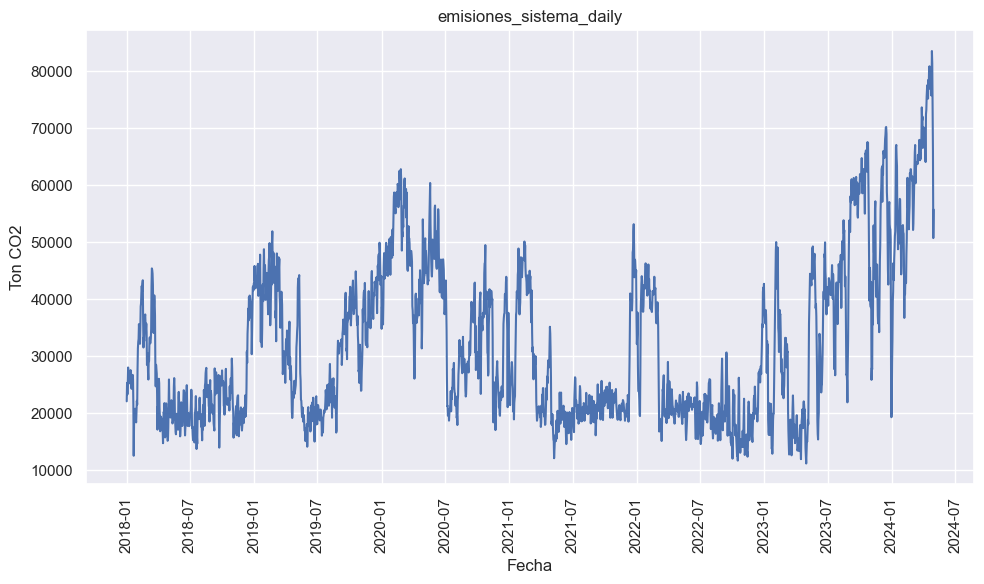

In [289]:
graficar(df_consolidated, 'emisiones_sistema_daily', 'Ton CO2')

Como podemos observar en la gráfica de la serie temporal, la variable `emisiones_sistema_daily` no tiene valores antes de enero de 2018. Esto puede deberse a que, antes de esa fecha, esta variable no se medía en el sistema.
Por lo tanto hace sentido reemplazar los valores nulos por ceros.

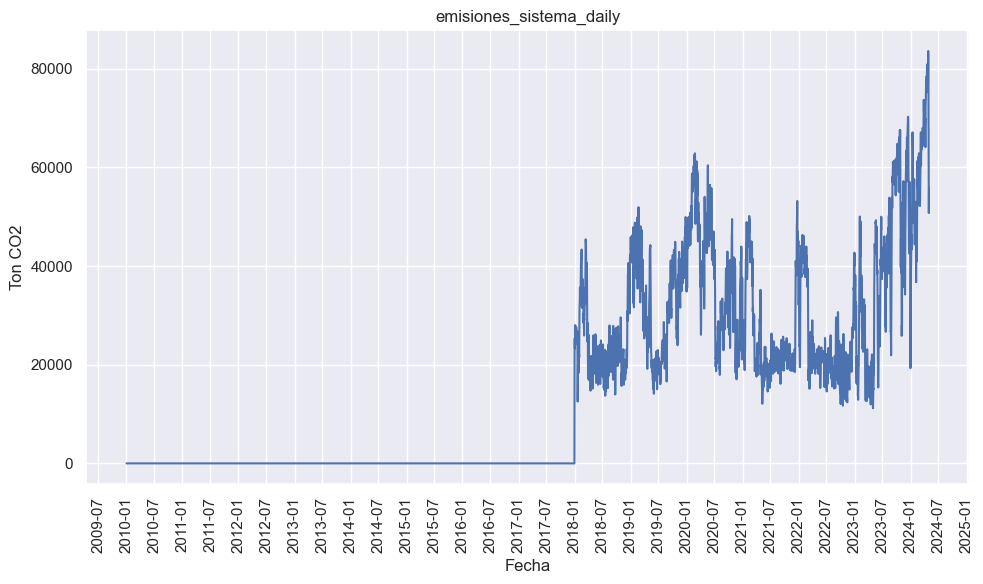

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5234 entries, 2010-01-01 to 2024-04-30
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   generacion_sistema_daily                 5234 non-null   float64
 1   generacion_ideal_sistema_daily           5234 non-null   float64
 2   perdidas_sistema_daily                   5234 non-null   float64
 3   volumen_util_energia_sistema_daily       5234 non-null   float64
 4   emisiones_sistema_daily                  5234 non-null   float64
 5   aportes_energia_sistema_daily            5234 non-null   int64  
 6   aportes_energia_mediaHist_sistema_daily  5234 non-null   int64  
 7   capacidad_util_energia_sistema_daily     5234 non-null   int64  
 8   demanda_real_sistema_daily               5234 non-null   float64
 9   exportaciones_sistema_daily              4829 non-null   float64
 10  importaciones_sistema_daily   

In [290]:
df_consolidated['emisiones_sistema_daily'] = df_consolidated['emisiones_sistema_daily'].fillna(0)
graficar(df_consolidated, 'emisiones_sistema_daily', 'Ton CO2')
df_consolidated.info()

### Variables `exportaciones_sistema_daily` y `Importaciones_sistema_daily`

Para el caso de las variables de importacion y exportacion de energia, hace sentido reemplazas los NaNs por cero, ya que significa que ese dia no hubo una importacion/exportacion.

In [291]:
df_consolidated['exportaciones_sistema_daily'] = df_consolidated['exportaciones_sistema_daily'].fillna(0)
df_consolidated['importaciones_sistema_daily'] = df_consolidated['importaciones_sistema_daily'].fillna(0)
df_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5234 entries, 2010-01-01 to 2024-04-30
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   generacion_sistema_daily                 5234 non-null   float64
 1   generacion_ideal_sistema_daily           5234 non-null   float64
 2   perdidas_sistema_daily                   5234 non-null   float64
 3   volumen_util_energia_sistema_daily       5234 non-null   float64
 4   emisiones_sistema_daily                  5234 non-null   float64
 5   aportes_energia_sistema_daily            5234 non-null   int64  
 6   aportes_energia_mediaHist_sistema_daily  5234 non-null   int64  
 7   capacidad_util_energia_sistema_daily     5234 non-null   int64  
 8   demanda_real_sistema_daily               5234 non-null   float64
 9   exportaciones_sistema_daily              5234 non-null   float64
 10  importaciones_sistema_daily   

# Exportacion del Dataset de Analitica Limpio

## CSV

In [292]:
df_consolidated.to_csv('./data/datos_analitica_sistema_electrico.csv')

## Base de Datos en AWS

In [293]:
dotenv.load_dotenv("vars.env", override=True)

db_user = os.getenv('DB_USER_AWS')
db_password = os.getenv('DB_PASSWORD_AWS')
db_host = os.getenv('DB_HOST_AWS')
db_port = os.getenv('DB_PORT_AWS')
db_name = os.getenv('DB_NAME_AWS')

conn = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}', echo=False)

In [294]:
df_consolidated.to_sql('analitica_sistema_electrico_colombia', conn, if_exists='replace', index=True)

234